In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('../')

In [4]:
import numpy as np
from tqdm import tqdm

from propinf.attack.attack_utils import AttackUtil
import propinf.data.ModifiedDatasets as data
from sklearn.model_selection import train_test_split

# import warnings
# warnings.filterwarnings("ignore")

# cat_columns, cont_columns = data.get_census_columns()
cat_columns, cont_columns = data.get_adult_columns()
# cat_columns, cont_columns = data.get_market_columns()
# cat_columns, cont_columns = data.get_heart_columns()

dataset = "adult"
df_train, df_test = data.load_data(dataset, one_hot=False)

In [5]:
categories = ['sex', 'marital-status']
target_attributes = [' Male', ' Divorced']
sub_categories = ['race']
sub_attributes = [' Black']

t0 = 0.01
t1 = 0.05

n_trials = 1
pois_list = [0.001, 0.003]

In [6]:
df_train['occupation'].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

# Our work

**In order to increase the size of target dataset, need to change code in ModifiedDataset.py**

In [7]:
num_query_trials = 5
avg_success = {}

attack_util = AttackUtil(
    target_model_layers=[32, 16],
    df_train=df_train,
    df_test=df_test,
    cat_columns=cat_columns,
)

for pois_idx, user_percent in enumerate(tqdm(pois_list)):

    avg_success[user_percent] = 0.0

    attack_util.set_attack_hyperparameters(
        categories=categories,
        target_attributes=target_attributes,
        sub_categories=sub_categories,
        sub_attributes=sub_attributes,
        subproperty_sampling=False,
        poison_percent=user_percent,
        poison_class=1,
        t0=t0,
        t1=t1,
        variance_adjustment=1.0,
        middle="median",
        num_queries=500,
        pois_random_seed=21,
        num_target_models=5,
        ntarget_samples=1500,
        nsub_samples=1500,
        allow_subsampling=False,
        allow_target_subsampling=False,
    )

    attack_util.set_shadow_model_hyperparameters(
        device="cpu",
        num_workers=1,
        batch_size=1024,
        layer_sizes=[32,16],
        verbose=False,
        mini_verbose=False,
        epochs=15,
        tol=1e-6,
    )

    for i in range(n_trials):

        attack_util.generate_datasets()

        attack_util.train_and_poison_target(need_metrics=False)

        (
            out_M0,
            out_M1,
            threshold,
            correct_trials,
        ) = attack_util.property_inference_categorical(
            num_shadow_models=4,
            query_trials=num_query_trials,
            query_selection="random",
            distinguishing_test="median",
        )

        avg_success[user_percent] = (
            avg_success[user_percent] + correct_trials / n_trials
        )


Before attempting to run the property inference attack, set hyperparameters using
        1. set_attack_hyperparameters()
        2. set_model_hyperparameters()


  0%|                                                                                                                                                                                 | 0/2 [00:00<?, ?it/s]/Users/chaudhari.ha/Research/snap-sp23/propinf/data/ModifiedDatasets.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dp.loc[:, label] = poison_class


Oversampling test queries


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1/2 [01:03<01:03, 63.71s/it]/Users/chaudhari.ha/Research/snap-sp23/propinf/data/ModifiedDatasets.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dp.loc[:, label] = poison_class


Oversampling test queries


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.85s/it]


In [9]:
avg_success

{0.001: 0.8, 0.003: 1.0}

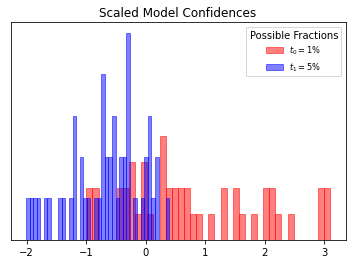

In [10]:
import matplotlib.pyplot as plt
plt.hist(out_M0, color="r", bins=40, alpha=0.5,label="$t_{0}=1\%$", edgecolor="r", density = True)
plt.hist(out_M1, color="b", bins= 40, alpha=0.5, label="$t_{1}=5\%$", edgecolor="b", density = True)
plt.legend(title = 'Property Sizes',fontsize = 8.3)
plt.title(f"Scaled Model Confidences")
plt.yticks(())
# plt.savefig("SMC-3P.pdf")
plt.show()